#### Synthetic zeeman and polarization data Reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_gen as dg
import recon_funcs as rf
import Sampler as sampler 

### Wavy Field Test

Using geometry, can derive the magnitude of the magnetic field wrt the LOS strength and cos2g

\begin{align}
    \cos^2\gamma &= \frac{bx^2+by^2}{bx^2+by^2+bz^2} = \frac{B_{pos}^2}{B^2}\\
    \sin^2\gamma &= 1 - \cos^2\gamma\\
    \cos\gamma &= \frac{B_{pos}}{B} \\
    \sin\gamma &= \frac{B_{los}}{B} \\
    \sin^2\gamma &= 1 - \cos^2\gamma = \frac{B_{los}^2}{B^2}\\
    B^2 &= \frac{B_{los}^2}{1 - \cos^2\gamma} \\
    B &= \frac{B_{los}}{\sqrt{1 - \cos^2\gamma}}\\
\end{align}

In [2]:
def zeeman_recon_3D(u): 
    # This code is not generic and can't work with 2.5D Zeeman reconstruction, need to incorporate both at some point.
    U     = u[0]
    Q     = u[1]
    COS2G = u[2]
    BLOS  = u[3]
    nBLOS = np.zeros((U.shape[0],U.shape[0]))
    print('new blos array size', np.shape(nBLOS))

    # need to grab closest BLOS value, not necessarily have information in each cell.
    # calculates fraction of index of i,j and then populates the new BLOS array with 
    # respective information. This way, BLOS array is the same size as U/Q/COS2G, and
    # BLOS information is extrapolated and smoothed. 
    if U.shape[0] > 1:
        for i in range(U.shape[0]):
            for j in range(U.shape[1]):
                ifrac = i/np.shape(U)[0]
                jfrac = j/np.shape(U)[1]
                iblos = int(ifrac*np.shape(BLOS)[0])
                jblos = int(jfrac*np.shape(BLOS)[1])
                print('BLOS size', BLOS.shape[0])
                if BLOS.shape[0] > 1:
                    nBLOS[i,j] = BLOS[iblos,jblos]
                else:
                    # print('BLOS value',BLOS[0][0])
                    nBLOS[i,j] = BLOS[0][0]
    
    else:
        nBLOS = BLOS
    
    print('U', np.shape(U), 'BLOS:', np.shape(nBLOS))

    if U.shape[0] != U.shape[1]:
        print('Input field is not square')
        return

    bx = np.zeros((U.shape[0],U.shape[0],U.shape[0]))
    by = np.zeros((U.shape[0],U.shape[0],U.shape[0]))
    bz = np.zeros((U.shape[0],U.shape[0],U.shape[0]))

    # for each cell in the 2D map
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            for n in range(bx.shape[0]):

                iQ        = Q[i][j]
                iU        = U[i][j]
                iCOS2G    = COS2G[i][j]
                iBLOS     = nBLOS[i][j]

                # Step 1. Plane-of-sky orientation from Q,U
                iphi = 0.5 * np.arctan2(iU, iQ)   # polarization angle

                # Step 2. Field magnitude from cos²γ and Zeeman
                Bmag = iBLOS / np.sqrt(1 - iCOS2G)

                # Step 3. POS amplitude
                Bperp = np.sqrt(np.maximum(Bmag**2 - iBLOS**2, 0))

                # Step 4. LOS component from Zeeman directly
                ibz = iBLOS.copy()
                
                # Step 5. Scale bx, by
                ibx = np.sin(iphi) * Bperp
                iby = np.cos(iphi) * Bperp

                # Total magnitude
                Btot = np.sqrt(bx**2 + by**2 + bz**2)
                #save
                # print('iPHI = ', iphi)

                # print('iBX = ', ibx)
    
                bx[i][j][n] = ibx
                by[i][j][n] = iby
                bz[i][j][n] = ibz
    
    # print('BTOT:', np.shape(Btot))

    return [bx,by,bz]

#### PCYCLE

In [ ]:
def p_vcycle(u1_list, b3_list, J, C): # u1_list restricted 2d DATA (U, Q, cos2g), b3_list is the prolonged layers, J is the level we're on

    if len(u1_list) != 0: 
        # this needs to change below
        if J == 1: # this is for the first cell only, where u11 = u21, and skips sampling
            
            u11 = u1_list.pop() # restricted layers, act as data
            
            b11 = zeeman_recon_3D(u11) # Reconstruct restricted 1x1 square into cube

            b31 = rf.prolong_3D(b11) # prolong into 2x2x2 cube
        
            b3_list.append(b31) # save 2x2x2 cube
            
            J = b31[0][0].shape[0]

            print('[checkpoint]: size of 1st cell recon:', np.shape(b11), 'size of 1st cell prolonged:', np.shape(b31))
            p_vcycle(u1_list, b3_list, J, C)

        else:            
            u12 = u1_list.pop() # restricted 2d DATA; every time a level is used, remove
            
            b12 = zeeman_recon_3D(u12) # reconstruct nxn square into nxnxn cube
            
            b32 = b3_list[-1] # grab previously prolonged cube
            
            print('[checkpoint]: B12 shape = ', np.shape(b12), 'B32 shape = ', np.shape(b32))

            if np.shape(b12) == np.shape(b32):
                # set parameters for sampling
                dtheta   = 0.4
                dphi     = 0.3
                R        = 12000
                rbins    = R//150
                ntrials  = 800
                nbins    = ntrials//80
                burn     = 500
                plotting = 0

                # Check Level:
                if u12[0][0].shape[0] < C:  # still growing, still prolongating

                    b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
                                              nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    print('[checkpoint]: Sampled B shape = ', np.shape(b22))

                    b33 = rf.prolong_3D(b22)

                    print('[checkpoint]: ','B22 shape = ', np.shape(b22), 'B33 shape = ', np.shape(b33))

                    J = b33[0][0].shape[0]

                    b3_list.append(b33)

                    p_vcycle(u1_list, b3_list, J, C)

                elif u12[0][0].shape[0] == C: # Hit last level. No more prolongation, but still want to sample 
                    print(u12[0][0].shape[0])
                    # Sample last level
                    b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
                                              nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    
                    b3_list.append(b22)

                    print('Ceiling Hit at J = ', u12[0][0].shape[0])
                    return
                else:
                    print('You have gone past input dimensions, something is wrong.')
            else:
                print('Reconstructed and Prolonged B field shapes do not match.')

    else:
        print('All levels reached, returning...') # once on last level, return


#### RCYCLE

In [4]:
def r_vcycle(tdmap, u1_list, b3_list, C):
    J = tdmap[0][0].shape[0]
    if J == 1: # check size is 1 cell
        # print('[checkpoint]: check for list of restricted layers')
        print('lvl == 1: Bottom reached; Begin Prolongation')
        p_vcycle(u1_list, b3_list, J, C) # start prolongation cycle at smallest cell

    else:
        u0 = rf.restrict_zeeman_min(tdmap) # restrict to lower resolution
        print('shape:',np.shape(u0[0]), np.shape(u0[3]))
        u1_list.append(u0) # save each restricted 2D level
        r_vcycle(u0, u1_list, b3_list, C) # restart cycle for next lvl
    

##### MULTIGRID

In [5]:
# u0 = initial observations, restricted: u0 = restrict(u)
# u1 = initially reconstructed/sampled, acts as data: u1 = reconstruct/sample(u0)
# u2 = sampled result from u1 data and u3 as guess: u2 = sample(u3|u1)
# u3 = prolonged data, starting point/initial guess: u3 = prolong(u2)
def multigrid(u): # takes in 2D array of data, and number of runs for sampler
    C    = u[0][0].shape[0]
    print('Ceiling = ', C)
    if (C % 2 == 0):
        u1_list = [] # restricted
        b2_list = [] # sampled
        b3_list = [] # prolonged

        u1_list.append(u) # save first level

        # grab restricted lvls and initially recon lvls (u0,u1)
        r_vcycle(u, u1_list, b3_list, C) # u = data, u0 enters with saved data array, u1 enters empty.
        print('[Multigrid]: Complete.')
    
    else:
        print('[Multigrid]: J must be even: C=%4i' % (C))

    return b3_list    

#### INPUTS

Create polarization maps. Also creates Zeeman information but for only a few measurements.

Loading data...
Reconstructing in 3 Dimensions
Ceiling =  16
Restricting... Level =  16
Restricting... Level =  4
shape: (8, 8) (2, 2)
Restricting... Level =  8
Restricting... Level =  2
shape: (4, 4) (1, 1)
Restricting... Level =  4
Restricting... Level =  1
shape: (2, 2) (1, 1)
Restricting... Level =  2
Restricting... Level =  1
shape: (1, 1) (1, 1)
lvl == 1: Bottom reached; Begin Prolongation
new blos array size (1, 1)
U (1, 1) BLOS: (1, 1)
Prolonging... Level =  1
[checkpoint]: size of 1st cell recon: (3, 1, 1, 1) size of 1st cell prolonged: (3, 2, 2, 2)
new blos array size (2, 2)
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
U (2, 2) BLOS: (2, 2)
[checkpoint]: B12 shape =  (3, 2, 2, 2) B32 shape =  (3, 2, 2, 2)
[checkpoint]: Theta Gaussian Peak =  1.6087958987970292 Phi =  1.3023907491762563
[checkpoint]: Theta Gaussian Peak =  1.5817505010455881 Phi =  1.3023907491762563
[checkpoint]: Theta Gaussian Peak =  1.6211845997802192 Phi =  1.3023907491762563
[checkpoint]: Theta Gaussi

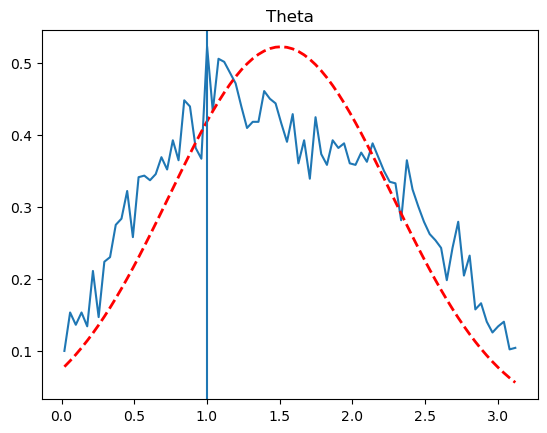

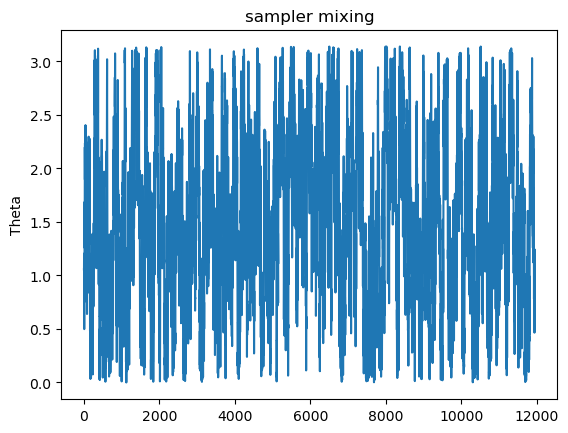

[checkpoint]: Sampled B shape =  (3, 2, 2, 2)
Prolonging... Level =  2
[checkpoint]:  B22 shape =  (3, 2, 2, 2) B33 shape =  (3, 4, 4, 4)
new blos array size (4, 4)
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
BLOS size 1
U (4, 4) BLOS: (4, 4)
[checkpoint]: B12 shape =  (3, 4, 4, 4) B32 shape =  (3, 4, 4, 4)
[checkpoint]: Theta Gaussian Peak =  1.65720729049822 Phi =  1.2865144251413105
[checkpoint]: Theta Gaussian Peak =  1.595840224400123 Phi =  1.2865144251413105
[checkpoint]: Theta Gaussian Peak =  1.5619066853218566 Phi =  1.2865144251413105
[checkpoint]: Theta Gaussian Peak =  1.6023411028584678 Phi =  1.2865144251413105
[checkpoint]: Theta Gaussian Peak =  1.5392063734533656 Phi =  1.2865144251413105
[checkpoint]: Theta Gaussian Peak =  1.5338292476245163 Phi =  1.2865144251413105
[checkpoint]: Theta Gaussian Peak =  1.632573082524889 Phi =  1.28

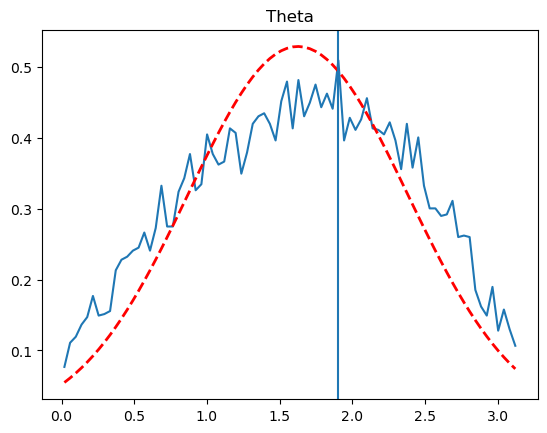

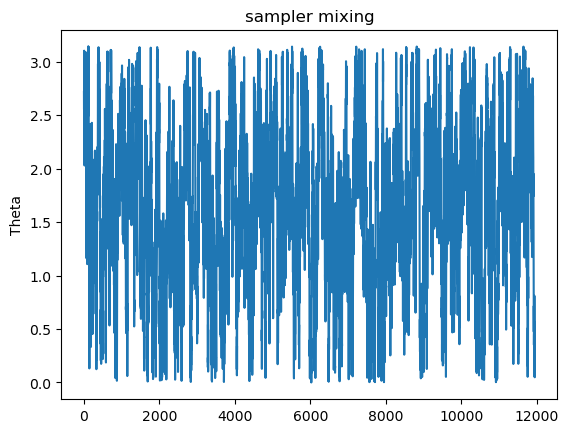

[checkpoint]: Sampled B shape =  (3, 4, 4, 4)
Prolonging... Level =  4
[checkpoint]:  B22 shape =  (3, 4, 4, 4) B33 shape =  (3, 8, 8, 8)
new blos array size (8, 8)
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
BLOS size 2
U (8, 8) BLOS: (8, 8)
[checkpoint]: B12 shape =  (3, 8, 8, 8) B32 s

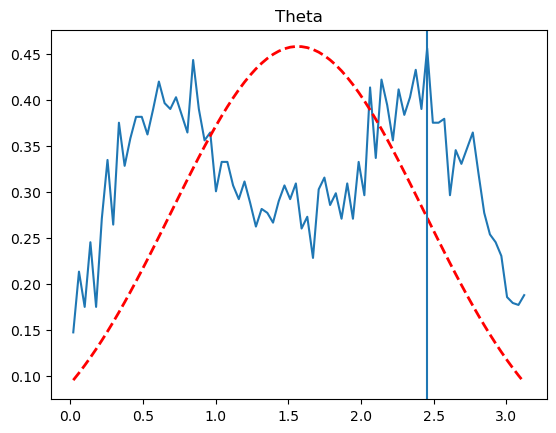

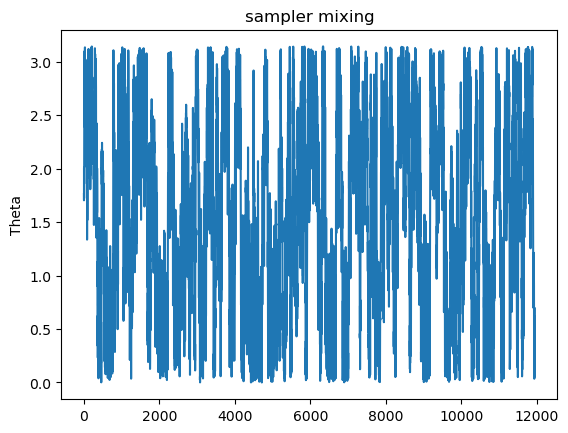

[checkpoint]: Sampled B shape =  (3, 8, 8, 8)
Prolonging... Level =  8
[checkpoint]:  B22 shape =  (3, 8, 8, 8) B33 shape =  (3, 16, 16, 16)
new blos array size (16, 16)
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BLOS size 4
BL

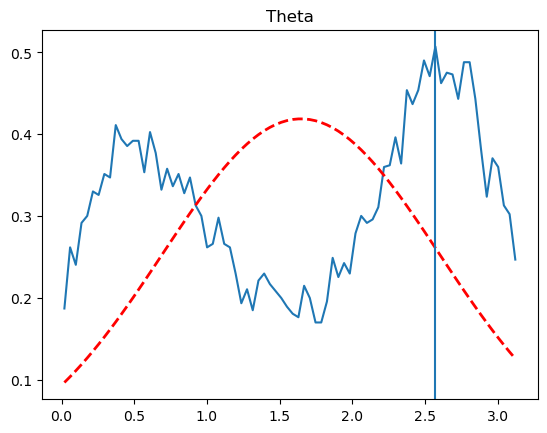

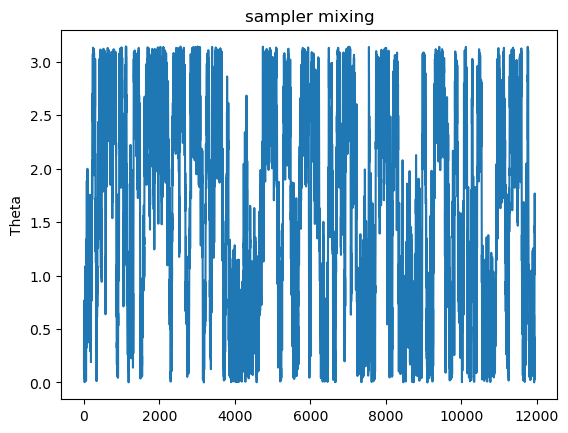

Ceiling Hit at J =  16
[Multigrid]: Complete.


In [6]:
print('===============')
print('Loading data...')
U, Q, COS, B_los_map, Bx, By, Bz = dg.wavy_zeeman_pol_min(box_length=16,amplitude=1.2,frequency=1,x_const=0.2,num_measurements=4,plotting=0)
UQpol_array = [U, Q, COS, B_los_map]

print('Reconstructing in 3 Dimensions')
d3_field = multigrid(UQpol_array)


In [7]:
bxr = d3_field[4][0]
byr = d3_field[4][1]
bzr = d3_field[4][2]

## Computing Residual:
* I have a 3D reconstructed field (16x16x16) which I need to compare to the input field (16x16x16).
* Previously, I was comparing Stokes U and Q in 2.5D, since that's all we will have observationally. This was fine because resolution was the same, and LOS was not reconstructed.
* I can take my Br components, and re-compute stokes map. But there most likely needs to be some line of sight integration? Possible copy what I use to create the sythetic field.
* Realized that issue is that I'm just taking a slice of the field, so how do I know i'm taking the right slice?!

Comparing Bx,By,Bz directly doesn't work bc Bx,By, inputs are incorrect size.

## Comparing 3D structure
* Okay, I can't compare the residual well. So I'm going to eyeball the structure of the input Bx,By,Bz field to the reconstructed Bxr, Byr, Bzr. This isn't the most reliable but will need to use it for now.

In [8]:
print(np.shape(Bx))
print(np.shape(bxr))

(16, 16, 16)
(16, 16, 16)


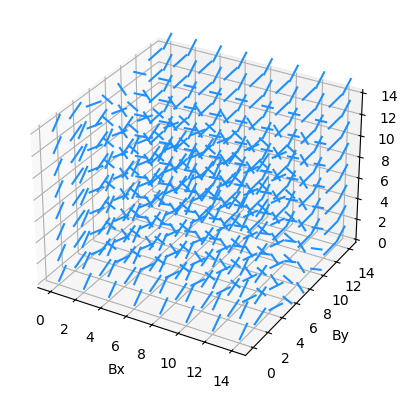

In [9]:
step = 2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = np.meshgrid(np.arange(Bx.shape[0]),
                        np.arange(By.shape[0]),
                        np.arange(Bz.shape[0]),indexing='xy')
ax.quiver(X[::step, ::step, ::step], Y[::step, ::step, ::step], Z[::step, ::step, ::step], Bx[::step, ::step, ::step], 
          By[::step, ::step, ::step], Bz[::step, ::step, ::step], length=1.5, normalize=True, arrow_length_ratio=0, 
          color='dodgerblue')
ax.set_xlabel('Bx')
ax.set_ylabel('By')
ax.set_zlabel('Bz')
plt.show()

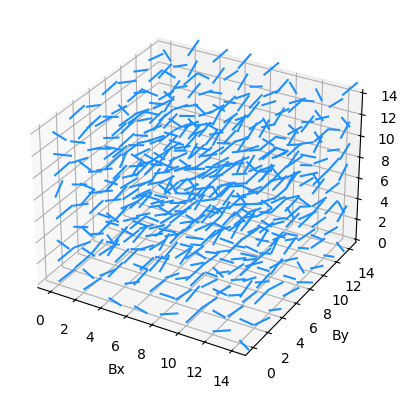

In [24]:
step = 2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = np.meshgrid(np.arange(bxr.shape[0]),
                        np.arange(byr.shape[0]),
                        np.arange(bzr.shape[0]),indexing='xy')
ax.quiver(X[::step, ::step, ::step], Y[::step, ::step, ::step], Z[::step, ::step, ::step], bxr[::step, ::step, ::step], 
          byr[::step, ::step, ::step], bzr[::step, ::step, ::step], length=1.5, normalize=True, arrow_length_ratio=0, 
          color='dodgerblue')
ax.set_xlabel('Bx')
ax.set_ylabel('By')
ax.set_zlabel('Bz')
plt.show()

## Compute stokes U/Q for recon field

In [13]:
icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g

print(np.shape(iu))



(16, 16, 16)


##### Plot U maps

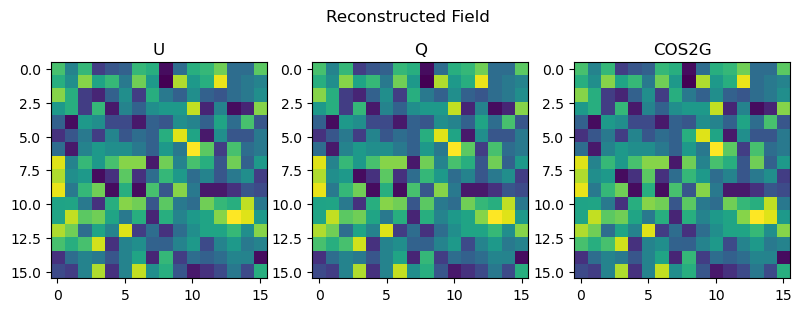

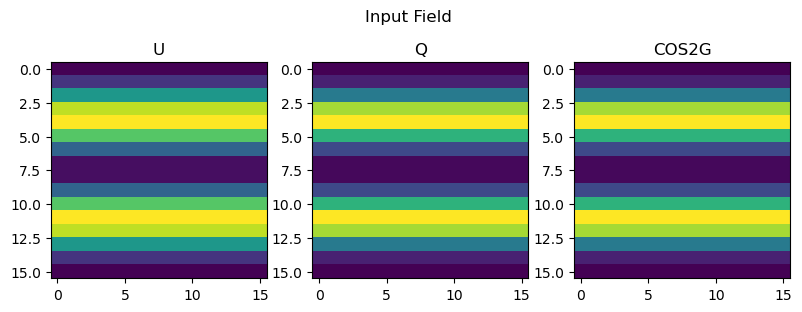

In [14]:
fig, ax = plt.subplots(1,3, figsize=(8,4))
# ax[0].imshow(U)
ax[0].imshow(iu[0, :, :])
ax[1].imshow(iq[0, :, :])
ax[2].imshow(icos2g[0, :, :])
ax[0].set_title('U')
ax[1].set_title('Q')
ax[2].set_title('COS2G')
plt.suptitle('Reconstructed Field')
plt.tight_layout(rect=[0, 0.03, 1, 1.2]) # Adjust top margin to make space for suptitle

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(U)
ax[1].imshow(Q)
ax[2].imshow(COS)
ax[0].set_title('U')
ax[1].set_title('Q')
ax[2].set_title('COS2G')
plt.suptitle('Input Field')
plt.tight_layout(rect=[0, 0.03, 1, 1.2]) # Adjust top margin to make space for suptitle

In [15]:
# resy = np.sqrt(np.mean((bx-bxr)**2 + (by-byr)**2 + (bz-bzr)**2))
residual = np.sqrt(np.mean((iu[0]-U)**2 + (iq[0]-Q)**2))
print(np.shape(iu[0]), np.shape(U))
print(residual)
# residual2 = np.sqrt(np.mean((iu-U)**2 + (iq-Q)**2) + (icos2g-COS)**2)
# print(residual2)


(16, 16) (16, 16)
0.442475305453868


# ++++++++++++++++++++++++++++++++++

### Torodial Field Test

In [ ]:
u, q, cos, blos, bx, by, bz = dg.torodial_zeeman_pol(box_length=10,alpha=0,plotting=1)

In [ ]:
bxr, byr, bzr = rf.zeeman_recon(u, q, cos, blos, plotting=1)

icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g


In [ ]:
residual = np.sqrt(np.mean((iu-u)**2 + (iq-q)**2))
print(residual)

In [ ]:
residual_array = []
alpha_array = []

for ia in np.linspace(0.1,10,1000):
    u, q, cos, blos, bx, by, bz = dg.torodial_zeeman_pol(box_length=10,alpha=ia,plotting=0)
    bxr, byr, bzr = rf.zeeman_recon(u, q, cos, blos, plotting=0)

    icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
    iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
    iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g

    residual = np.sqrt(np.mean((iu-u)**2 + (iq-q)**2))
    residual_array.append(residual)
    alpha_array.append(ia)



In [ ]:
plt.plot(alpha_array, residual_array, marker='o', linestyle='none', color = 'gray')
plt.ylabel('Residual')
plt.xlabel('Alpha Value')
plt.title('LOS 2.5D Recon Test Torodial Field')

Use this program below later, when I need to start making REAL synthetic zeeman maps. 
Maybe implement with Athena++. 
For now, I can just use what I have above. 

In [ ]:
# def synthetic_zeeman_pol_wvy(box_length,amplitude,frequency,y_const,plotting):

#     x = np.linspace(0, 2*np.pi, box_length)
#     y = np.linspace(0, 2*np.pi, box_length)
#     z = np.linspace(0, 2*np.pi, box_length)
#     X, Y, Z = np.meshgrid(x, y, z, indexing="xy")

#     # field geoemtry - wavy
#     angle = amplitude * np.cos(frequency * Y)
#     Bx = np.full_like(X, y_const)      
#     Bz = np.sin(angle)                 
#     By = np.cos(angle)

#     # calculate Stokes U/Q/Cos2g
#     cos2g         = (Bx**2+By**2)/(Bx**2+By**2+Bz**2)
#     q             = (By**2-Bx**2)/(Bx**2+By**2) * cos2g
#     u             = 2*Bx*By/(Bx**2+By**2) * cos2g
#     phi           = 0.5*np.arctan2(u,q)
#     pol           = np.sqrt(u**2+q**2) # which is the same as cos2g in this approach

#     los = np.array([0., 0., 1.])   # unit vector; change as desired
#     los = los / np.linalg.norm(los)

#     # compute B_parallel field: pointwise dot product
#     B_parallel_3d = los[0]*Bx + los[1]*By + los[2]*Bz   # shape (nx,ny,nz)

#     # integrate or average along LOS axis.
#     # If LOS is along z, the axis to collapse is index 2 (the third axis).
#     B_los_map = np.mean(B_parallel_3d, axis=2)   # shape (nx, ny)

#     # Fake spectral line parameters (arbitrary, non-physical)
#     nv = 512
#     v = np.linspace(-5.0, 5.0, nv)   # velocity (or freq) axis in arbitrary units
#     sigma_v = 0.6                    # line width
#     I0 = 1.0                         # peak intensity

#     # weak-Zeeman proportionality constant (choose units so signal is visible)
#     # In real physics this depends on line rest freq and Landé g; here treat as tunable scalar
#     zeta = 0.2   # (velocity unit per unit B) -- tune to get visible splitting

#     # precompute base line (centered at v=0)
#     base_line = I0 * np.exp(-0.5 * (v/sigma_v)**2)

#     nx, ny = box_length, box_length
#     I_cube = np.zeros((nx, ny, nv))
#     V_cube = np.zeros((nx, ny, nv))

#     # loop over sightlines 
#     for i in range(nx):
#         for j in range(ny):
#             Bbar = B_los_map[i, j]                 # LOS field for that pixel
#             delta_v = zeta * Bbar                  # shift of sigma units
#             # Shifted right/left circular polarization profiles:
#             # RCP shifted to +delta, LCP shifted to -delta (or vice versa depending sign convention)
#             I_R = I0 * np.exp(-0.5 * ((v - delta_v)/sigma_v)**2)
#             I_L = I0 * np.exp(-0.5 * ((v + delta_v)/sigma_v)**2)
#             I = 0.5*(I_R + I_L)
#             V = I_R - I_L                          # circular pol. difference (Stokes V)
#             I_cube[i, j] = I
#             V_cube[i, j] = V

#     # Add gaussian observational noise (optional)
#     noise_rms = 5e-3
#     rng = np.random.default_rng(42)
#     V_cube += rng.normal(scale=noise_rms, size=V_cube.shape)
#     I_cube += rng.normal(scale=noise_rms, size=I_cube.shape)

#     # Diagnostics: maps you might want
#     # peak amplitude of V (signed) maximum circular polarization signal at each picel. Observable = 'Zeeman detection strength"
#     V_peak = np.max(V_cube, axis=2)  
#     # integrated absolute V (a simple proxy) Rough measure of total Polarized signal across line
#     V_int = np.trapezoid(np.abs(V_cube), x=v, axis=2)

#     # grab first slice of Stokes U/Q/COS2G
#     U = u[:,:,0]
#     Q = q[:,:,0]
#     COS = cos2g[:,:,0]


#     if plotting == 1:
#         # Plot B_los_map
#         fig, ax = plt.subplots(2,2, figsize=(8,8))
#         im0 = ax[0,0].imshow(B_los_map.T, origin='lower')#, extent=[x.min(), x.max(), y.min(), y.max()])
#         ax[0,0].set_title(r'B$_{LOS}$ (z)')
#         ax[0,0].set_xlabel('x')
#         ax[0,0].set_ylabel('y')
#         plt.colorbar(im0, ax=ax[0,0])
#         # Plot V_peak
#         im1 = ax[1,0].imshow(V_peak.T, origin='lower')#, extent=[x.min(), x.max(), y.min(), y.max()])
#         ax[1,0].set_title('peak Stokes V')
#         ax[1,0].set_xlabel('x')
#         ax[1,0].set_ylabel('y')
#         plt.colorbar(im1, ax=ax[1,0])

#         # plot sample spectrum at center pixel
#         i0, j0 = nx//2, ny//2
#         ax[1,1].plot(v, I_cube[i0, j0], label='I')
#         ax[1,1].plot(v, V_cube[i0, j0], label='V (x10)')
#         ax[1,1].plot(v, 10*V_cube[i0, j0], label='10*V')  # scaled so visible
#         ax[1,1].legend()
#         ax[1,1].set_title(f'Spectra at pixel ({i0},{j0})')

#         # plot stokes U and Q Map
#         X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]), indexing='ij')
#         factor = 1 / np.max(COS)

#         phi = 0.5 * np.arctan2(U, Q)
#         x_scaled = np.sin(phi) * COS * factor
#         y_scaled = np.cos(phi) * COS * factor

#         ax[0,1].set_title('Stokes U and Q Map')
#         ax[0,1].quiver(X,Y,x_scaled,y_scaled, scale=2, scale_units='xy', headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue', alpha=0.7)

#         ax[0,1].set_xlabel('X')
#         ax[0,1].set_ylabel('Y')

#         plt.tight_layout()
#         plt.show()

#     return U, Q, COS, B_los_map.T

# # u, q, cos, blos = zeeman_wvy(box_length=16, amplitude=1.2, frequency=2.0, y_const=0.5)
# # print(u, q, cos, blos)